In [2]:
%matplotlib inline
%matplotlib nbagg

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pandas as pd
import random
from collections import defaultdict
import pickle

from typing import *
from IPython.display import Image, display, clear_output
from plotting import make_vae_plots

sns.set_style("whitegrid")

from Code.Dataloader import dataloader
from Code.MakeDict import findEDF
from Code.MNEplotter import MNEPlotter 

# 1. Introduction

##  1.1) Set up a script for loading data

In [5]:
#Andreas path
data_path=r"C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset"

In [ ]:
#Blanca's path
data_path=r"C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset"

In [6]:
#Define paths for dataset


# Initialize dataloader
edfDict=findEDF(DataDir=data_path)
DL=dataloader(Time_interval=1,Overlap=0,Data_paht=data_path)
lables_decoding=DL.one_hot_eoncoding

#### [START SKIP] 

SKIP THIS PART UNLESS SETTINGS ARE CHANGED.

Find all annotations for al windows.

In [8]:
#Find all atifacts in dataset takes 2 minutes
edfDict,annothlist=DL.anno_mapping(edfDict) 

KeyError: 'path'

In [4]:
#So save it
np.save('testIDX.npy',annothlist)

#### [END SKIP] 

In [9]:
#Or load it
annothlist=np.load('testIDX.npy',allow_pickle=True)

In [10]:
def make_batch(IDXlist, size=24, Nlable=6):
    """
    make balance dataset, sampling with replacement.
    
    """
    filelist = []
    windowlist = []

    if size % Nlable != 0:
        raise Exception(f"Batch size must be devedible by {Nlable}")
    fromset = int(size / Nlable)

    for i in range(Nlable):
        elements = np.random.randint(0, len(IDXlist[i]), fromset)
        for e in elements:
            window = int(IDXlist[i][e][0])
            try:  # See if window already is in list else append it
                winidx = windowlist.index(window)
                filelist[winidx].append(int(IDXlist[i][e][1]))
            except ValueError:
                windowlist.append(window)
                filelist.append([int(IDXlist[i][e][1])])

    return windowlist, filelist

In [11]:
def reshape(x):
    x = x.view(original_shape)
    return x

In [12]:
def formatData(raw):
    global original_shape
    data = {'X':[raw[0][win]['X'] for win in raw[0].keys()], 'Y':[raw[0][win]['Y'] for win in raw[0].keys()]}
    original_shape = data['X'][0].shape
    data['X'] = torch.Tensor(np.array([x.flatten() for x in data['X']])).type(torch.float)
    data['Y'] = torch.Tensor(np.array([y for y in data['Y']])).type(torch.float)
    return data

## 1.2) Plot randomly chosen samples on a grid

In [13]:
idx = [0]
test_dict = DL.loadDict(edfDict,index = idx);

Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\002\00000254\s005_2010_11_15\00000254_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


In [14]:
sample_data = formatData(test_dict)
sample_x = sample_data['X']
sample_y = sample_data['Y']

In [15]:
ploter=MNEPlotter(CH_names=DL.CH_names,lableEncoding=DL.one_hot_eoncoding) #Intitalic plotter

<IPython.core.display.Javascript object>


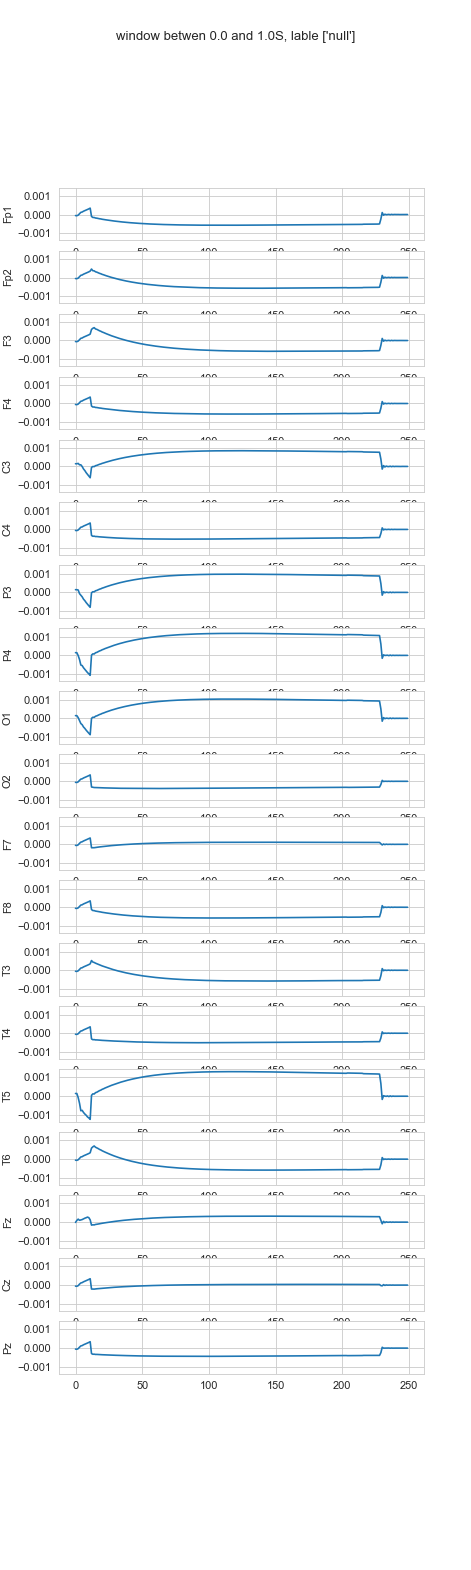

In [16]:
ploter.plot(test_dict[0]['window_0'])

#### 1.3) Using  the transform argument,  implement dynamic binarization,  where  the  binarized {0,1} pixels are sampled using the pixel intensity as the probability - DONE

# 2. VAE Implementation

## 2.1 Setting up the model

In [17]:
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        z=self.mu+self.sigma*self.sample_epsilon()
        return z

        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        normal_dist=torch.distributions.normal.Normal(self.mu,self.sigma)
        return normal_dist.log_prob(z) 

##### Implement a VAE as atorch.nn.Module.

(a)  Implement a method.encode(...)that encodes a batch ofx.

(b)  Implement a method.decode(...)that decodes a batch ofz.

(c)  Implement a method.sample(...)that generates samples.

(d)  Implement a method.elbo(...)that computes the ELBO

In [18]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=128, out_features=2*latent_features) # <- note the 2*latent_features
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=self.observation_features)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def sample(self, x:Tensor, z = False):
        loss, diagnostics, outputs = vi(vae, x)
        if z:
            pz = outputs['pz']   
            return pz.sample()
        px = outputs['px']
        return px.sample()

        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encode(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        '''
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        self.px_logits = px_logits
        dist = torch.distributions.bernoulli.Bernoulli(logits=px_logits)
        '''      
        h_x = self.decoder(z)
        #mu, log_sigma =  h_z.chunk(2, dim=-1)
        #dist = torch.distributions.normal.Normal(h_z, h_z)

        return torch.distributions.normal.Normal(h_x, h_x)
      

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # define the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz, 'z': z}

    def elbo(self,x:Tensor,beta=1):
        _, diagnostics, _ = vi(vae, x)

        return diagnostics['elbo']
    
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        self.test = px.sample()
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo =log_px-kl # <- your code here
        beta_elbo =log_px-self.beta * kl # <- your code here
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs

In [19]:
latent_features = 2
# Vi 
vi = VariationalInference(beta=1.0)

vae = VariationalAutoencoder(sample_x[0].shape, latent_features)
print(vae)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4750, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=4750, bias=True)
  )
)


### (Report)Generate 64 samples from theuntrained modeland plot them on a 8×8 grid

In [39]:
untrained_samples = vae.sample(sample_x)
import importlib
importlib.reload(plotting)

NameError: name 'plotting' is not defined

In [21]:
out_untrained_samples = [reshape(i) for i in untrained_samples]

<IPython.core.display.Javascript object>


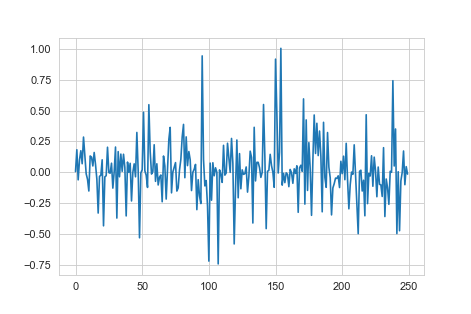

<IPython.core.display.Javascript object>


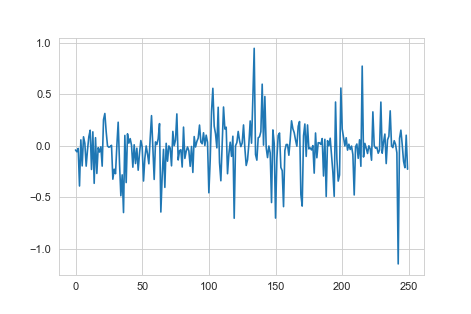

<IPython.core.display.Javascript object>


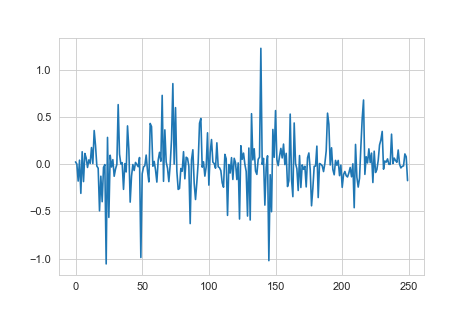

<IPython.core.display.Javascript object>


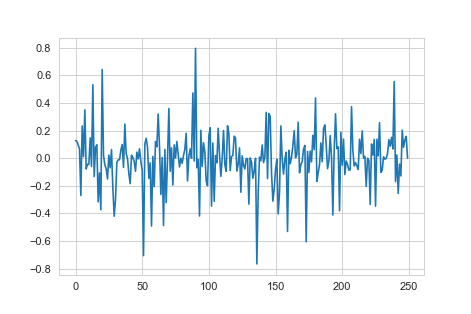

<IPython.core.display.Javascript object>


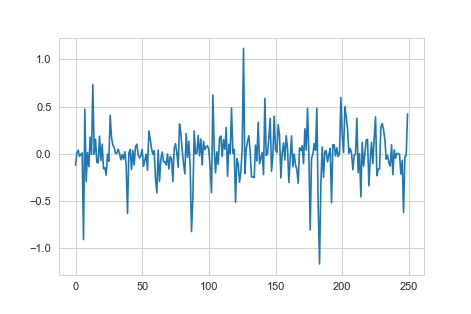

<IPython.core.display.Javascript object>


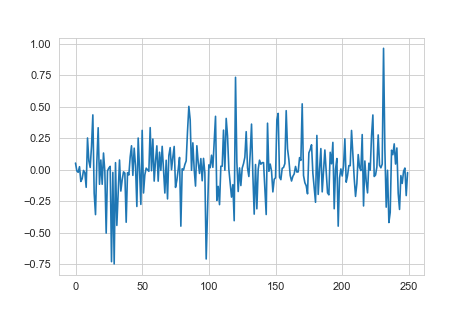

<IPython.core.display.Javascript object>


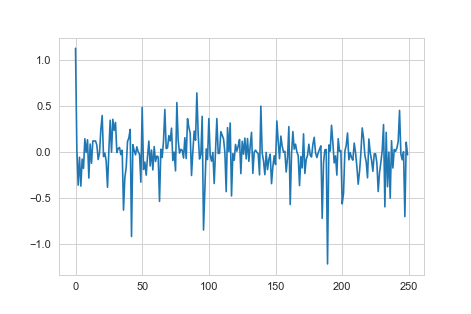

<IPython.core.display.Javascript object>


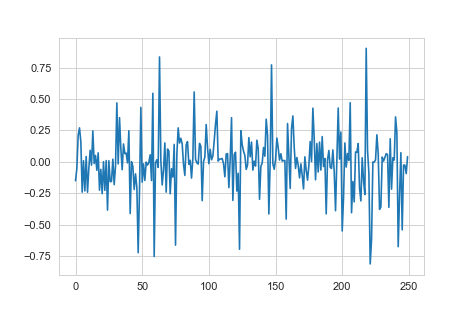

<IPython.core.display.Javascript object>


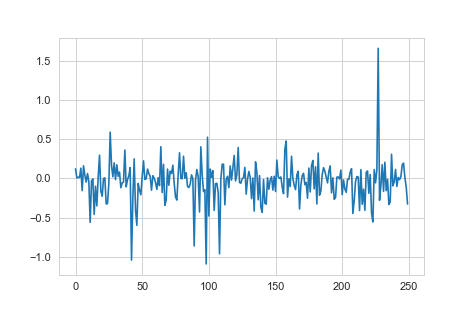

<IPython.core.display.Javascript object>


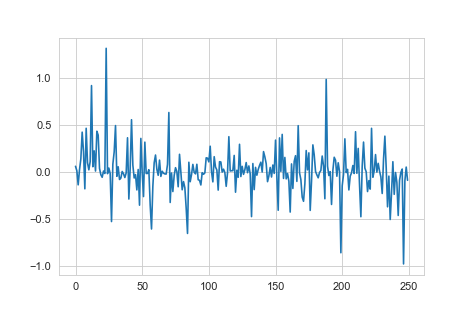

<IPython.core.display.Javascript object>


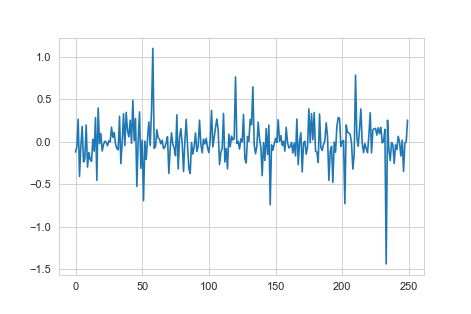

<IPython.core.display.Javascript object>


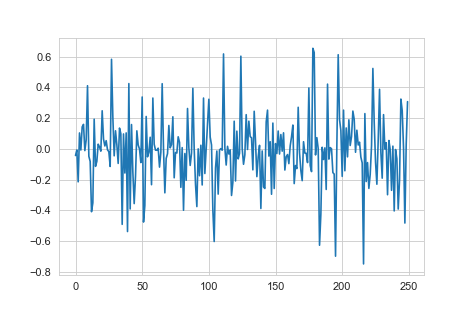

<IPython.core.display.Javascript object>


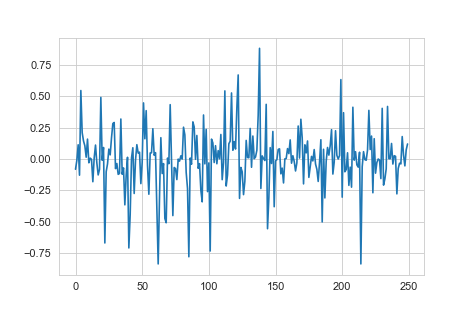

<IPython.core.display.Javascript object>


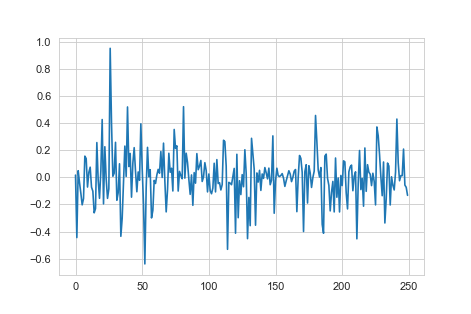

<IPython.core.display.Javascript object>


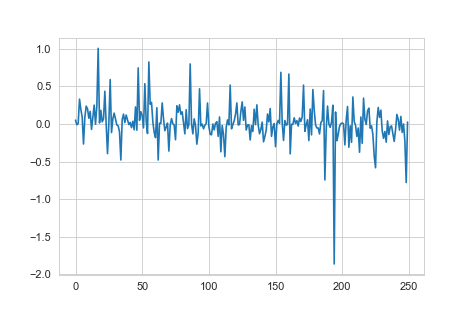

<IPython.core.display.Javascript object>


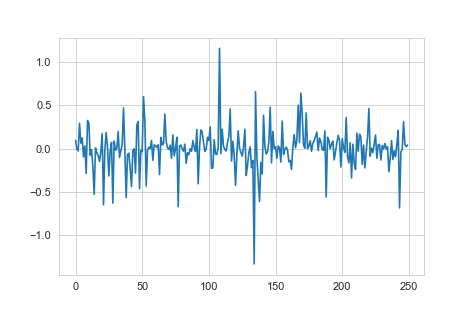

<IPython.core.display.Javascript object>


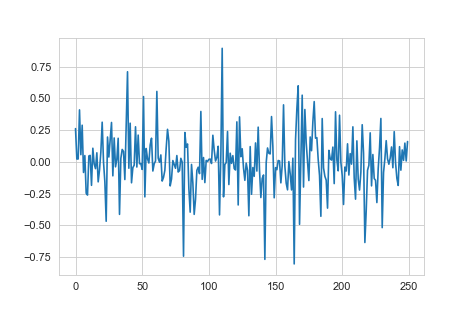

<IPython.core.display.Javascript object>


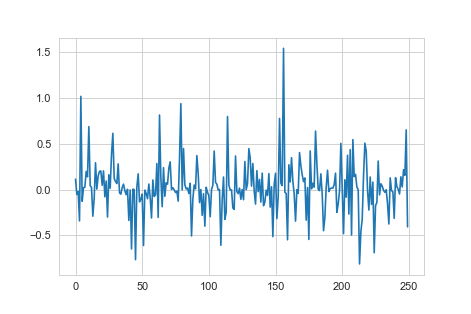

<IPython.core.display.Javascript object>


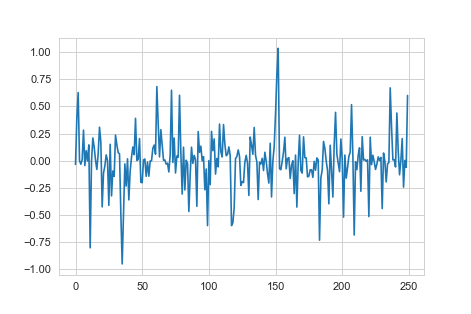

In [22]:
for channel in out_untrained_samples[0]:
    plt.figure()
    plt.plot(channel)
    plt.show()

##### (Report)Compute the ELBO of 64 samples from thetraining setusing theuntrained modeland report the number.

In [23]:
elbo = vae.elbo(sample_x)

In [24]:
plt.plot(elbo.detach().numpy()) # Why does this not work?
plt.show()

## 2.2 Setting up the training

In [29]:
from collections import defaultdict

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Vi 
vi = VariationalInference(beta=1.0)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device="cpu"
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)

>> Using device: cpu


### 1. Implement atrain(...)function that performs one epoch of training

In [26]:
def train(vae,dataLoader,n_batches= 10):
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for batch in range(n_batches):
        windowlist,filelist=make_batch(annothlist,12)
        _,batch_X,_=dataLoader.loadBatch(edfDict=edfDict,filelist=filelist,windowlist=windowlist)
        
        x = torch.Tensor(np.array([x.flatten() for x in batch_X])).type(torch.float)
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

    return training_epoch_data
            

### 2. Implement atest(...)function that evaluates the model on the test set.

In [27]:
def test(vae,dataLoader,validation_data):
    global batch_Y
    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        windowlist,filelist=make_batch(annothlist,12)
        _,batch_X,batch_Y=dataLoader.loadBatch(edfDict=edfDict,filelist=filelist,windowlist=windowlist)
        
        x = torch.Tensor(np.array([x.flatten() for x in batch_X])).type(torch.float)
        x = x.to(device)
        y = torch.Tensor(np.array(batch_Y)).type(torch.float)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
        return validation_data


### 3. Train the model for some time (e.g.  100-200 epochs).  Remember to save thestatedictof themodel usingtorch.save!

[**SKIP the above if the training is finished. Just load the model.**]

In [28]:
# train
epoch = 0
num_epochs = 50
validation_data = defaultdict(list)

while epoch < num_epochs:
    if epoch%10 == 0:
      print("Epoch {0}/{1}".format(epoch,num_epochs))
    epoch+= 1
    
    # gather data for the full epoch
    training_epoch_data = train(vae,DL,n_batches= 3)
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    validation_data = test(vae,DL,validation_data)

Epoch 0/50
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\104\00010418\s009_2013_06_17\00010418_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 392999  =      0.000 ...  1571.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\070\00007078\s001_2010_01_25\00007078_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ...  1215.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 

EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\060\00006052\s001_2009_10_08\00006052_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 352499  =      0.000 ...  1409.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\034\00003437\s006_2014_10_20\00003437_s006_t004

Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\033\00003363\s007_2013_01_17\00003363_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...   600.998 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006535\s004_2012_07_17\00006535_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', '

IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\076\00007647\s001_2011_02_07\00007647_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\03_tcp_ar_a\010\00001027\s002_2004_01_27\00001027_s002_t004.edf...
EDF file 

Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\105\00010551\s002_2013_07_24\00010551_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\079\00007937\s003_2015_04_01\00007937_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 617215  =      0.000 ...  2410.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 

IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\054\00005462\s004_2012_12_17\00005462_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1280511  =      0.000 ...  2500.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\080\00008092\s007_2013_06_01\00008092_s007_t000.edf...
EDF file detected
Set

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006535\s003_2012_07_16\00006535_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\And

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\077\00007755\s001_2011_05_12\00007755_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320999  =      0.000 ...  1283.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\070\00007078\s001_2010_01_25\00007078_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ...  1215.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F

Creating raw.info structure...
Reading 0 ... 305249  =      0.000 ...  1220.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\082\00008295\s006_2012_05_09\00008295_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 573951  =      0.000 ...  1120.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_datas

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\095\00009514\s001_2012_12_04\00009514_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322815  =      0.000 ...  1260.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\064\00006479\s001_2010_05_05\00006479_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4'

Creating raw.info structure...
Reading 0 ... 326911  =      0.000 ...  1276.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\082\00008295\s006_2012_05_09\00008295_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 491519  =      0.000 ...   959.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008830\s001_2012_05_22\00008830_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 355249  =      0.000 ...  1420.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\079\00007937\s003_2015_04_01\00007937_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 617215  =      0.000 ...  2410.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 334999  =      0.000 ...  1339.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\078\00007870\s001_2011_07_05\00007870_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\033\00003363\s007_2013_01_17\00003363_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...   600.998 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008767\s001_2012_05_21\00008767_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3',

Creating raw.info structure...
Reading 0 ... 518499  =      0.000 ...  2073.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\084\00008466\s001_2012_02_09\00008466_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_da

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\100\00010024\s001_2013_02_18\00010024_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 374499  =      0.000 ...  1497.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\094\00009485\s001_2012_10_19\00009485_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 340249  =      0.000 ...  1360.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 305249  =      0.000 ...  1220.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\059\00005932\s004_2013_03_14\00005932_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 412249  =      0.000 ...  1648.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\An

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\033\00003363\s007_2013_01_17\00003363_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...   600.998 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4

Creating raw.info structure...
Reading 0 ... 78079  =      0.000 ...   304.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\084\00008466\s001_2012_02_09\00008466_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_datas

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\075\00007575\s006_2015_06_15\00007575_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319487  =      0.000 ...  1247.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\092\00009232\s002_2012_10_10\00009232_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3',

PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\084\00008477\s001_2012_11_29\00008477_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 439749  =      0.000 ...  1758.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t010.edf...
EDF file

Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\102\00010209\s006_2013_08_13\00010209_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6'

Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\083\00008303\s004_2011_11_24\00008303_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150249  =      0.000 ...   600.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_a

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\093\00009362\s001_2012_08_24\00009362_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 481249  =      0.000 ...  1924.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\02_tcp_le\065\00006501\s001_2010_01_03\00006501_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
PHOTIC PH
DC1-DC
DC2-DC
DC3-DC
DC4-DC
DC5-DC
DC6-DC
DC7-DC
DC

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 381249  =      0.000 ...  1524.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\086\00008634\s001_2012_02_29\00008634_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 325999  =      0.000 ...  1303.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\02_tcp_le\038\00003849\s001_2007_04_19\00003849_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
PHOTIC PH
DC1-DC
DC2-DC
DC3-DC
DC4-DC
DC5-DC
DC6-DC
DC7-DC
DC8-D

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\082\00008295\s006_2012_05_09\00008295_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...   600.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\U

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006531\s004_2011_11_15\00006531_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ...  1218.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\080\00008092\s007_2013_06_01\00008092_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1988607  =      0.000 ...  7767.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\094\00009417\s001_2012_08_21\00009417_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350207  =      0.000 ...  1367.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\104\00010421\s001_2013_06_14\00010421_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 469749  =      0.000 ...  1878.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4

Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\056\00005649\s002_2010_06_03\00005649_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 686499  =      0.000 ...  2745.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\art

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\023\00002348\s014_2015_07_27\00002348_s014_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 322815  =      0.000 ...  1260.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\075\00007575\s006_2015_06_15\00007575_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319487  =      0.000 ...  1247.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1'

Reading 0 ... 372999  =      0.000 ...  1491.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\092\00009232\s004_2012_10_11\00009232_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\090\00

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\104\00010467\s001_2013_06_27\00010467_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 381249  =      0.000 ...  1524.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\064\00006462\s002_2010_06_11\00006462_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\And

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\054\00005412\s001_2009_10_29\00005412_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\068\00006833\s001_2010_08_04\00006833_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 292749  =      0.000 ...  1170.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 611583  =      0.000 ...  2388.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\019\00001981\s007_2015_03_30\00001981_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\096\00009603\s001_2012_11_21\00009603_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318999  =      0.000 ...  1275.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008723\s001_2012_04_16\00008723_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345999  =      0.000 ...  1383.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4'

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...   600.998 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\054\00005462\s004_2012_12_17\00005462_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1280511  =      0.000 ...  2500.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\03_tcp_ar_a\131\00013103\s001_2015_09_30\00013103_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 485887  =      0.000 ...  1897.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\099\00009932\s008_2014_10_04\00009932_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 603647  =      0.000 ...  2357.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4'

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 331999  =      0.000 ...  1327.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\002\00000254\s005_2010_11_15\00000254_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameter

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\033\00003363\s007_2013_01_17\00003363_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...   600.998 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\100\00010023\s002_2013_02_21\00010023_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3',

Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\019\00001981\s007_2015_03_30\00001981_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 57343  =      0.000 ...   223.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_a

Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006598\s001_2010_03_22\00006598_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\075\00007575\s006_2015_06_15\00007575_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319487  =      0.000 ...  1247.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', '

EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\068\00006880\s002_2012_08_02\00006880_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313499  =      0.000 ...  1253.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\068\00006852\s001_2010_08_06\00006852_s001_t000.edf...
EDF file de

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 898749  =      0.000 ...  3594.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\078\00007870\s001_2011_07_05\00007870_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameter

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\033\00003363\s007_2013_01_17\00003363_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...   600.998 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008767\s001_2012_05_21\00008767_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3',

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 611583  =      0.000 ...  2388.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\094\00009413\s001_2012_10_03\00009413_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 749999  =      0.000 ...  2999.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\U

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\101\00010135\s002_2013_02_19\00010135_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\094\00009414\s005_2013_05_21\00009414_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338687  =      0.000 ...  1322.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 249249  =      0.000 ...   996.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\086\00008615\s001_2012_01_13\00008615_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311999  =      0.000 ...  1247.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\An

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\064\00006462\s002_2010_06_11\00006462_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F

Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\082\00008295\s006_2012_05_09\00008295_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 573951  =      0.000 ...  1120.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_datas

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\102\00010212\s001_2013_01_23\00010212_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 600749  =      0.000 ...  2402.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\092\00009232\s004_2012_10_11\00009232_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1988607  =      0.000 ...  7767.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\089\00008971\s001_2012_07_17\00008971_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 263999  =      0.000 ...  1055.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning l

Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\064\00006462\s002_2010_06_11\00006462_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 749999  =      0.000 ...  2999.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\100\00010079\s004_2013_07_02\00010079_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\And

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\100\00010024\s001_2013_02_18\00010024_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 374499  =      0.000 ...  1497.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\076\00007679\s001_2011_01_12\00007679_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318749  =      0.000 ...  1274.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F

Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\054\00005462\s004_2012_12_17\00005462_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1280511  =      0.000 ...  2500.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\064\00006462\s002_2

Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\02_tcp_le\044\00004473\s002_2008_02_12\00004473_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310249  =      0.000 ...  1240.996 secs...
PHOTIC PH
DC1-DC
DC2-DC
DC3-DC
DC4-DC
DC5-DC
DC6-DC
DC7-DC
DC8-DC
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\075\00007575\s006_2015_06_15\00007575_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 251903  =      0.000 ...   983.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', '

Reading 0 ... 216575  =      0.000 ...   845.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\02_tcp_le\065\00006501\s001_2010_01_03\00006501_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
PHOTIC PH
DC1-DC
DC2-DC
DC3-DC
DC4-DC
DC5-DC
DC6-DC
DC7-DC
DC8-DC
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifa

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\084\00008477\s001_2012_11_29\00008477_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 439749  =      0.000 ...  1758.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4

EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\067\00006746\s004_2010_12_06\00006746_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302749  =      0.000 ...  1210.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\102\00010267\s001_2013_01_04\00010267_s001_t000

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\104\00010453\s002_2013_07_24\00010453_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326999  =      0.000 ...  1307.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\025\00002508\s002_2009_11_13\00002508_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312749  =      0.000 ...  1250.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F

Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\085\00008530\s001_2012_01_04\00008530_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\art

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\057\00005740\s008_2014_10_28\00005740_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008767\s001_2012_05_21\00008767_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4'

Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006535\s003_2012_07_16\00006535_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_datas

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\03_tcp_ar_a\010\00001027\s002_2004_01_27\00001027_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 110799  =      0.000 ...   276.998 secs...
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006531\s004_2011_11_15\00006531_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304749  =      0.000 ...  1218.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 

Reading 0 ... 2636799  =      0.000 ... 10299.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\064\00006448\s001_2010_05_17\00006448_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\096\0000

Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\098\00009800\s001_2012_03_19\00009800_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332749  =      0.000 ...  1330.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008767\s001_2012_05_21\00008767_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', '

EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\075\00007575\s006_2015_06_15\00007575_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 319487  =      0.000 ...  1247.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\034\00003465\s004_2010_11_08\00003465_s004_t001.edf...
EDF file de

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 384255  =      0.000 ...  1500.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\094\00009417\s001_2012_08_21\00009417_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350207  =      0.000 ...  1367.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplear

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\023\00002348\s012_2015_07_25\00002348_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4

Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006535\s003_2012_07_16\00006535_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_datas

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\092\00009232\s004_2012_10_11\00009232_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\03_tcp_ar_a\010\00001027\s002_2004_01_27\00001027_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 121599  =      0.000 ...   303.998 secs...
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 370499  =      0.000 ...  1481.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\096\00009603\s001_2012_11_21\00009603_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 318999  =      0.000 ...  1275.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\086\00008615\s001_2012_01_13\00008615_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311999  =      0.000 ...  1247.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F

Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...   600.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\102\00010212\s001_2013_01_23\00010212_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 600749  =      0.000 ...  2402.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artif

Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\098\00009800\s001_2012_03_19\00009800_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332749  =      0.000 ...  1330.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\019\00001981\s007_2015_03_30\00001981_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8

Reading 0 ... 749999  =      0.000 ...  2999.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\023\00002348\s014_2015_07_27\00002348_s014_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 241919  =      0.000 ...   944.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\034\00003

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\101\00010158\s003_2013_01_14\00010158_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\094\00009434\s002_2013_03_15\00009434_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 378249  =      0.000 ...  1512.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4'

Creating raw.info structure...
Reading 0 ... 350207  =      0.000 ...  1367.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\104\00010421\s001_2013_06_14\00010421_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 469749  =      0.000 ...  1878.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_data

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008767\s001_2012_05_21\00008767_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\007\00000715\s010_2014_08_07\00000715_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 78079  =      0.000 ...   304.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 

Creating raw.info structure...
Reading 0 ... 100499  =      0.000 ...   401.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\093\00009362\s001_2012_08_24\00009362_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 481249  =      0.000 ...  1924.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_da

Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\078\00007852\s001_2011_06_02\00007852_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311499  =      0.000 ...  1245.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\089\00008971\s001_2012_07_17\00008971_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 263999  =      0.000 ...  1055.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4',

Reading 0 ... 307711  =      0.000 ...   600.998 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\080\00008092\s006_20

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008738\s006_2013_06_06\00008738_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 155647  =      0.000 ...   607.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 352499  =      0.000 ...  1409.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\098\00009800\s001_2012_03_19\00009800_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332749  =      0.000 ...  1330.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\052\00005230\s002_2010_09_07\00005230_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303999  =      0.000 ...  1215.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\009\00000906\s005_2003_04_27\00000906_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 239999  =      0.000 ...   599.997 secs...
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O

Creating raw.info structure...
Reading 0 ... 600749  =      0.000 ...  2402.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artif

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008767\s001_2012_05_21\00008767_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4'

Creating raw.info structure...
Reading 0 ... 310999  =      0.000 ...  1243.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\068\00006811\s002_2010_02_12\00006811_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 518499  =      0.000 ...  2073.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_da

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008723\s001_2012_04_16\00008723_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345999  =      0.000 ...  1383.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\104\00010418\s009_2013_06_17\00010418_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 392999  =      0.000 ...  1571.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 

Reading 0 ... 306749  =      0.000 ...  1226.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\009\00000906\s017_2012_03_02\00000906_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 60159  =      0.000 ...   234.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\033\000033

Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008767\s001_2012_05_21\00008767_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\064\00006479\s001_2010_05_05\00006479_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4',

EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\102\00010212\s001_2013_01_23\00010212_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 600749  =      0.000 ...  2402.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006531\s004_2011_11_15\00006531_s004_t000.edf...


Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\060\00006091\s004_2013_10_07\00006091_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 391749  =      0.000 ...  1566.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\104\00010467\s001_2013_06_27\00010467_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 381249  =      0.000 ...  1524.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', '

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\054\00005462\s004_2012_12_17\00005462_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1280511  =      0.000 ...  2500.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\080\00008092\s006_2013_06_01\00008092_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P

Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\068\00006822\s001_2010_07_29\00006822_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296499  =      0.000 ...  1185.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\art

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\104\00010453\s002_2013_07_24\00010453_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326999  =      0.000 ...  1307.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\02_tcp_le\065\00006501\s001_2010_01_03\00006501_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
PHOTIC PH
DC1-DC
DC2-DC
DC3-DC
DC4-DC
DC5-DC
DC6-DC
D

Creating raw.info structure...
Reading 0 ... 57343  =      0.000 ...   223.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\091\00009177\s001_2012_05_02\00009177_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 372999  =      0.000 ...  1491.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_datas

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\033\00003363\s007_2013_01_17\00003363_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...   600.998 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P

Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\080\00008092\s006_2013_06_01\00008092_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_datas

Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\02_tcp_le\044\00004473\s003_2008_02_14\00004473_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...
PHOTIC PH
DC1-DC
DC2-DC
DC3-DC
DC4-DC
DC5-DC
DC6-DC
DC7-DC
DC8-DC
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\100\00010079\s004_2013_07_02\00010079_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', '

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\082\00008295\s001_2011_11_07\00008295_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 417749  =      0.000 ...  1670.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\And

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\062\00006224\s002_2010_01_06\00006224_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', '

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\064\00006462\s002_2010_06_11\00006462_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\068\00006811\s002_2010_02_12\00006811_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 518499  =      0.000 ...  2073.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\094\00009413\s001_2012_10_03\00009413_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 749999  =      0.000 ...  2999.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 320999  =      0.000 ...  1283.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\085\00008582\s001_2012_02_09\00008582_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 314249  =      0.000 ...  1256.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006535\s006_2012_07_19\00006535_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 611583  =      0.000 ...  2388.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\100\00010024\s001_2013_02_18\00010024_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 374499  =      0.000 ...  1497.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', '

Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_datas

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\084\00008466\s001_2012_02_09\00008466_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\03_tcp_ar_a\010\00001027\s002_2004_01_27\00001027_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 141599  =      0.000 ...   353.998 secs...
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O

Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
PHOTIC PH
DC1-DC
DC2-DC
DC3-DC
DC4-DC
DC5-DC
DC6-DC
DC7-DC
DC8-DC
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008723\s001_2012_04_16\00008723_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345999  =      0.000 ...  1383.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\054\00005462\s004_2012_12_17\00005462_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1280511  =      0.000 ...  2500.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4',

Reading 0 ... 292749  =      0.000 ...  1170.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\03_tcp_ar_a\046\00004671\s017_2015_03_27\00004671_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2636799  =      0.000 ... 10299.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\065\00

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\084\00008477\s001_2012_11_29\00008477_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 439749  =      0.000 ...  1758.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\009\00000906\s005_2003_04_27\00000906_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 239999  =      0.000 ...   599.997 secs...
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2'

Reading 0 ... 296249  =      0.000 ...  1184.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\033\00003363\s007_2013_01_17\00003363_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...   600.998 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008

Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008767\s001_2012_05_21\00008767_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\064\00006462\s002_2010_06_11\00006462_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4',

Reading 0 ... 155647  =      0.000 ...   607.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008738\s004_2013_06_04\00008738_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326911  =      0.000 ...  1276.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\073\00007372\s001_2010_05_19

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 306499  =      0.000 ...  1225.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\096\00009693\s001_2011_12_14\00009693_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 310749  =      0.000 ...  1242.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameter

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\092\00009265\s001_2012_03_09\00009265_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4

Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...   600.998 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artif

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\068\00006811\s002_2010_02_12\00006811_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 518499  =      0.000 ...  2073.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\03_tcp_ar_a\046\00004671\s017_2015_03_27\00004671_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2636799  =      0.000 ... 10299.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 

Creating raw.info structure...
Reading 0 ... 301749  =      0.000 ...  1206.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\02_tcp_le\065\00006514\s008_2010_05_03\00006514_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 269249  =      0.000 ...  1076.996 secs...
PHOTIC PH
DC1-DC
DC2-DC
DC3-DC
DC4-DC
DC5-DC
DC6-DC
DC7-DC
DC8-DC
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\054\00005462\s004_2012_12_17\00005462_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1280511  =      0.000 ...  2500.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008156\s010_2015_08_27\00008156_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', '

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...   600.998 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplea

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\03_tcp_ar_a\046\00004671\s017_2015_03_27\00004671_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2636799  =      0.000 ... 10299.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\02_tcp_le\038\00003849\s001_2007_04_19\00003849_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
PHOTIC PH
DC1-DC
DC2-DC
DC3-DC
DC4-DC
DC5-DC
DC6-DC
DC7-DC
DC8-DC
['F

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323327  =      0.000 ...  1262.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008770\s001_2012_05_23\00008770_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 347999  =      0.000 ...  1391.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\104\00010421\s001_2013_06_14\00010421_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 469749  =      0.000 ...  1878.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4'

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376999  =      0.000 ...  1507.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\068\00006811\s002_2010_02_12\00006811_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 518499  =      0.000 ...  2073.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\083\00008303\s004_2011_11_24\00008303_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 150249  =      0.000 ...   600.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\080\00008092\s007_2013_06_01\00008092_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1988607  =      0.000 ...  7767.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\068\00006847\s001_2010_08_06\00006847_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\An

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\009\00000906\s018_2013_01_22\00000906_s018_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 376999  =      0.000 ...  1507.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\084\00008466\s001_2012_02_09\00008466_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 

Creating raw.info structure...
Reading 0 ... 303749  =      0.000 ...  1214.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\068\00006835\s001_2010_08_02\00006835_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 294499  =      0.000 ...  1177.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\art

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\092\00009244\s001_2012_03_19\00009244_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\086\00008615\s001_2012_01_13\00008615_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311999  =      0.000 ...  1247.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4'

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\002\00000297\s004_2012_02_28\00000297_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362499  =      0.000 ...  1449.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\093\00009362\s001_2012_08_24\00009362_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 481249  =      0.000 ...  1924.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\080\00008092\s006_2013_06_01\00008092_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3',

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 389749  =      0.000 ...  1558.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\052\00005276\s002_2011_03_04\00005276_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\An

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008767\s001_2012_05_21\00008767_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4

Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\084\00008466\s001_2012_02_09\00008466_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\02_tcp_l

Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\104\00010453\s002_2013_07_24\00010453_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326999  =      0.000 ...  1307.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\Andre\Desktop\Deeplearning local\artifact_dataset\artifact_dataset\01_tcp_ar\092\00009244\s001_2012_03_19\00009244_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4'

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 417749  =      0.000 ...  1670.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


KeyboardInterrupt: 

In [64]:
# save model
path = "model.pt"
torch.save(vae.state_dict(), path)

**[END SKIP]**

In [15]:
# train model
path = "model.pt"
vae.load_state_dict(torch.load(path))

<All keys matched successfully>

### 4.(Report)Generate 64 samples from thetrained modeland plot them on a 8×8 grid.

In [24]:
trained_samples = vae.sample(sample_x)

In [25]:
out_trained_samples = [reshape(i) for i in trained_samples]

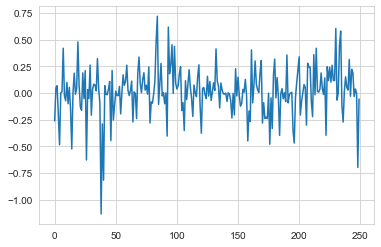

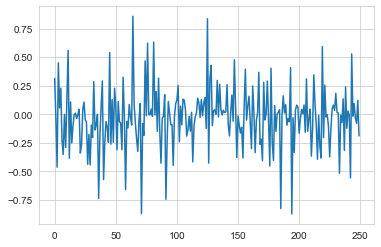

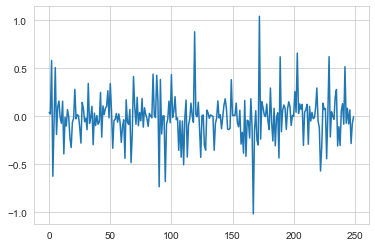

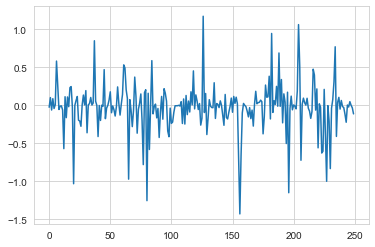

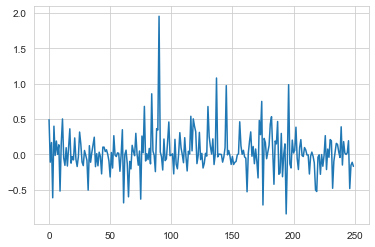

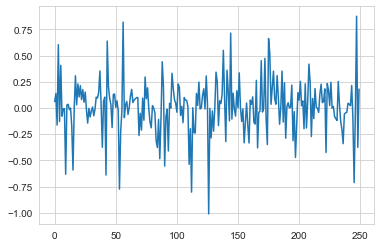

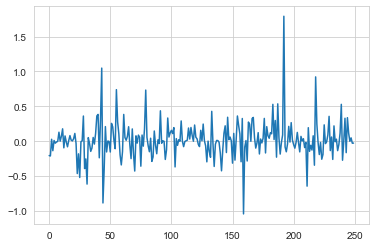

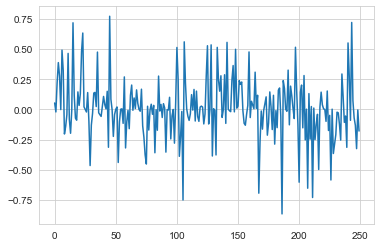

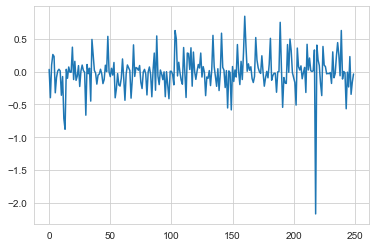

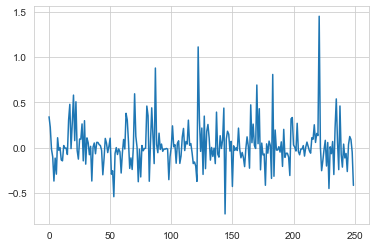

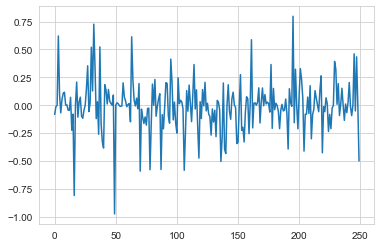

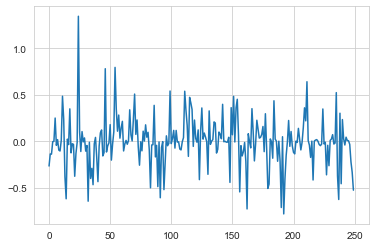

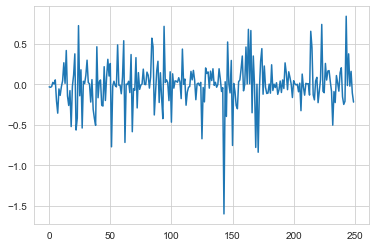

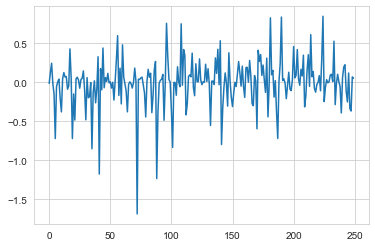

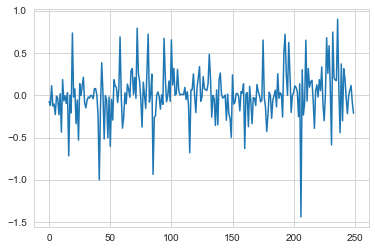

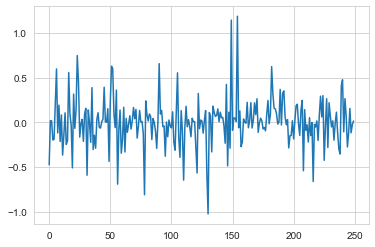

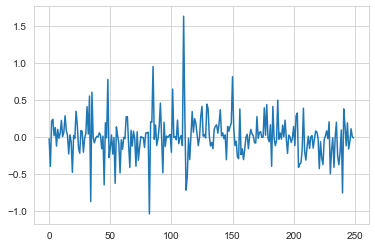

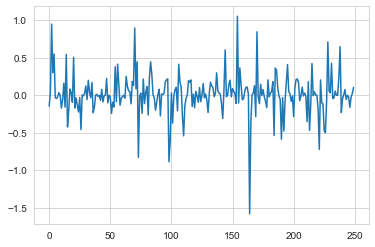

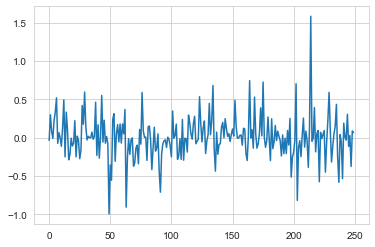

In [29]:
for channel in out_trained_samples[0]:
    plt.figure()
    plt.plot(channel)
    plt.show()

### 5.(Report)Evaluate thetrained modelon the test set and report the number.

Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\03_tcp_ar_a\046\00004671\s017_2015_03_27\00004671_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2636799  =      0.000 ... 10299.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'AF6', 'PO6h', 'TP8h', 'FFT7', 'P8', 'FCC3', 'AF3', 'CP3h', 'PPO10h', 'PO5h', 'FC6h', 'FFC3h', 'PPO8h', 'CCP4', 'PO8', 'PPO1h', 'FCCz', 'AF10', 'CPP3', 'PPO5', 'AFz', 'POO9h', 'I1', 'FC3', 'TP10', 'AF6h', 'FFC1h', 'FTT7h', 'CCP4h', 'PO4h', 'C6', 'PO10', 'PPO5h', 'CP2h', 'CPP2', 'CP1', 'FCC5h', 'CCP3', 'F10', 'FFT7h', 'AF5h', 'Fp1h', 'C5h', 'P10', 'M1', 'PPO7h', 'POO2', 'FFC4', 'AFF4', 'FC4', 'CCP6h', 'CPP3h', 'POO1', 'AFF10', 'FTT8h', 'CCP6', 'Fpz', 'CP2', 'F10h', 'AFp1h', 'F1', 'FT9', 'TP8', 'F9h', 'TTP7h', 'TTP8h', '

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\074\00007441\s001_2010_10_08\00007441_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'AF6', 'PO6h', 'TP8h', 'FFT7', 'P8', 'FCC3', 'AF3', 'CP3h', 'PPO10h', 'PO5h', 'FC6h', 'FFC3h', 'PPO8h', 'CCP4', 'PO8', 'PPO1h', 'FCCz', 'AF10', 'CPP3', 'PPO5', 'AFz', 'POO9h', 'I1', 'FC3', 'TP10', 'AF6h', 'FFC1h', 'FTT7h', 'CCP4h', 'PO4h', 'C6', 'PO10', 'PPO5h', 'CP2h', 'CPP2', 'CP

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\064\00006479\s001_2010_05_05\00006479_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'AF6', 'PO6h', 'TP8h', 'FFT7', 'P8', 'FCC3', 'AF3', 'CP3h', 'PPO10h', 'PO5h', 'FC6h', 'FFC3h', 'PPO8h', 'CCP4', 'PO8', 'PPO1h', 'FCCz', 'AF10', 'CPP3', 'PPO5', 'AFz', 'POO9h', 'I1', 'FC3', 'TP10', 'AF6h', 'FFC1h', 'FTT7h', 'CCP4h', 'PO4h', 'C6', 'PO10', 'PPO5h', 'CP2h', 'CPP2', 'CP

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006566\s001_2010_04_15\00006566_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313749  =      0.000 ...  1254.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'AF6', 'PO6h', 'TP8h', 'FFT7', 'P8', 'FCC3', 'AF3', 'CP3h', 'PPO10h', 'PO5h', 'FC6h', 'FFC3h', 'PPO8h', 'CCP4', 'PO8', 'PPO1h', 'FCCz', 'AF10', 'CPP3', 'PPO5', 'AFz', 'POO9h', 'I1', 'FC3', 'TP10', 'AF6h', 'FFC1h', 'FTT7h', 'CCP4h', 'PO4h', 'C6', 'PO10', 'PPO5h', 'CP2h', 'CPP2', 'CP

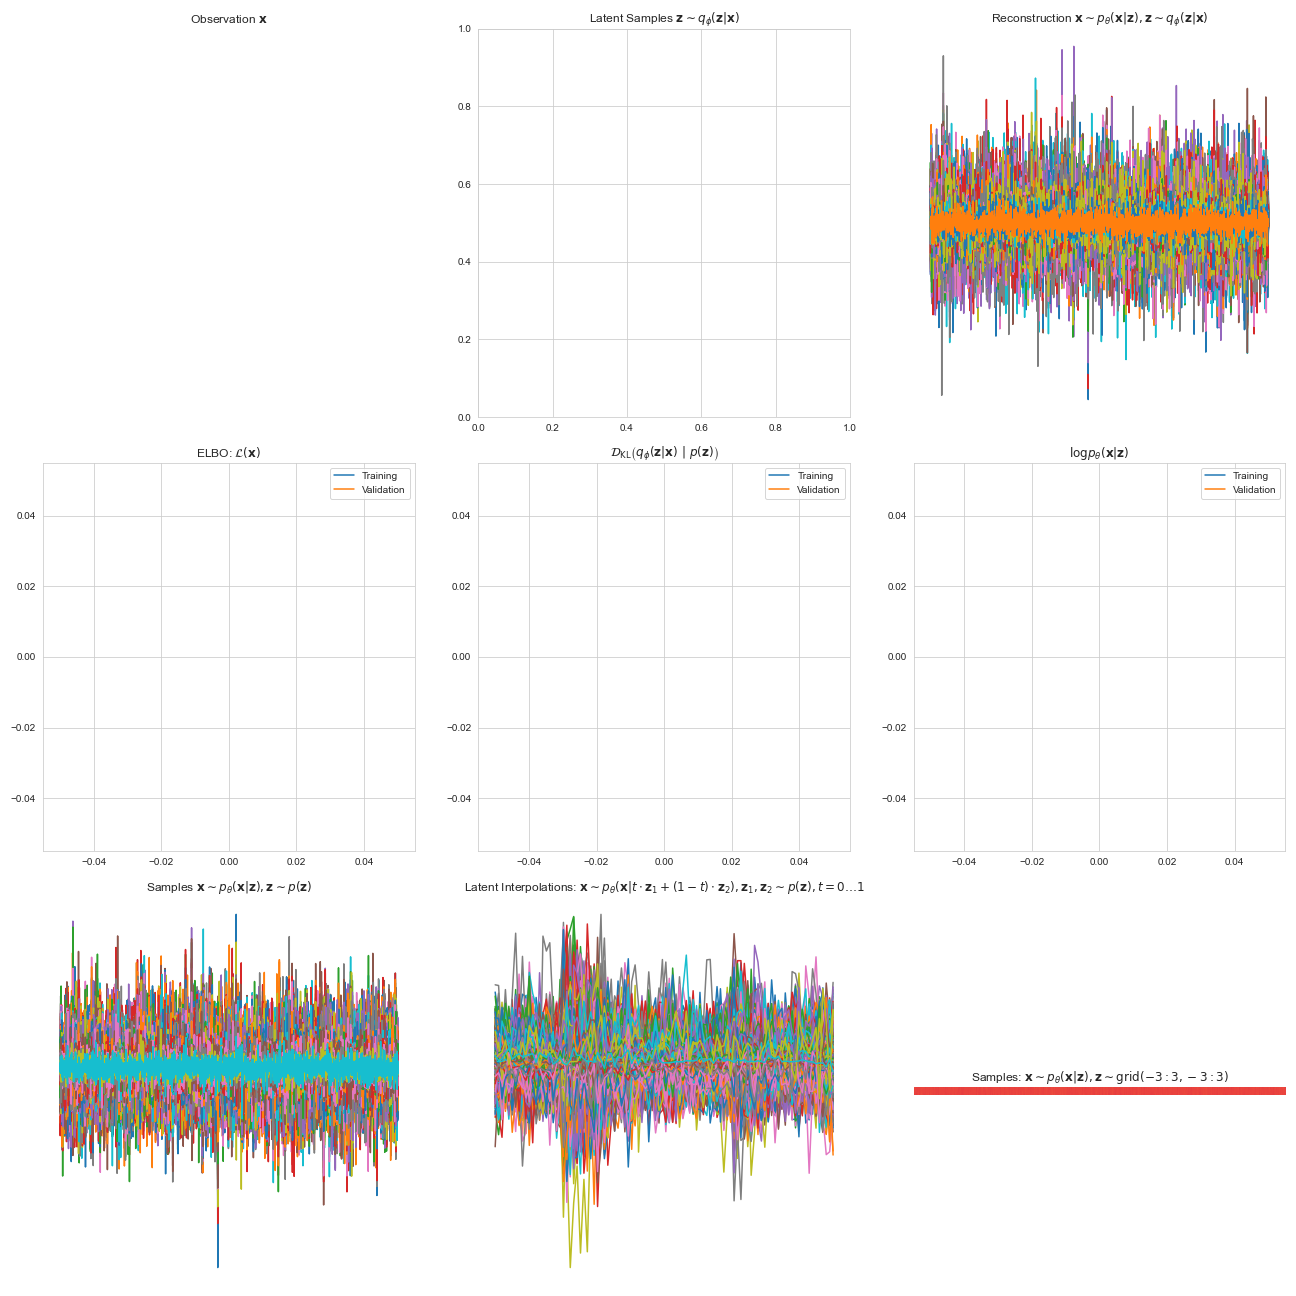

In [16]:
# Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
with torch.no_grad():
    windowlist,filelist=make_batch(annothlist,12)
    _,batch_X,_=DL.loadBatch(edfDict=edfDict,filelist=filelist,windowlist=windowlist)
    loss, diagnostics, outputs = vi(vae,sample_x)
make_vae_plots(vae, sample_x[0], sample_y[0], outputs, training_data, validation_data)

# 2.3  Semi-Supervised VAE (M1)

We have now trained a VAE on the full unlabeled dataset.  We will now implement the M1 modelfromSemi-Supervised Learning with Deep Generative Models. This amounts to simply traininga classifier on top of the representations learned by our VAE.

In [105]:
from sklearn import svm

def discriminativeTraining(vae,dataLoader,n_batches=10):
    global z
    global y
    
    windowlist,filelist=make_batch(annothlist,12)
    _,batch_X,batch_Y=dataLoader.loadBatch(edfDict=edfDict,filelist=filelist,windowlist=windowlist)

    x = torch.Tensor(np.array([x.flatten() for x in batch_X])).type(torch.float)
    y = torch.Tensor(np.array([(yi == 1).nonzero()[0] for yi in batch_Y]))        

    z = torch.empty(x.size()[0],2)

    for i in range(len(x)):
        z[i] = vae.posterior(x[i]).sample()
        
    for batch in range(n_batches):
        windowlist,filelist=make_batch(annothlist,12)
        _,batch_X,batch_Y=dataLoader.loadBatch(edfDict=edfDict,filelist=filelist,windowlist=windowlist)

        x = torch.Tensor(np.array([x.flatten() for x in batch_X])).type(torch.float)
        y = torch.cat((y,torch.Tensor(np.array([(yi == 1).nonzero()[0] for yi in batch_Y]))),0)     
        
        zi = torch.empty(x.size()[0],2)

        for i in range(len(x)):
            zi[i] = vae.posterior(x[i]).sample()
        z = torch.cat((z,zi))

    clf = svm.SVC()
    clf.fit(z, y) 
    return clf

In [94]:
windowlist,filelist=make_batch(annothlist,12)
_,batch_X,batch_Y=DL.loadBatch(edfDict=edfDict,filelist=filelist,windowlist=windowlist)

Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\073\00007372\s001_2010_05_19\00007372_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'AFF8h', 'AFF3', 'F1', 'P9', 'FCC4', 'F3h', 'FC4h', 'POO3h', 'AFF7', 'AF1', 'CP3h', 'PO3', 'PO8', 'C1', 'CCP6h', 'POO1', 'AFp1', 'F2h', 'PPO9', 'I2', 'TTP7h', 'CCP5h', 'PPO8h', 'POO6', 'AF9h', 'FT7h', 'AFF5', 'CP4', 'A

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\052\00005230\s003_2012_02_28\00005230_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 363999  =      0.000 ...  1455.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008738\s004_2013_06_04\00008738_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 326911  =      0.000 ...  1276.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'AFF8h', 'A

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


**[SKIP]** Skip this section if training is not needed.

In [106]:
SVC = discriminativeTraining(vae, DL)

Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\094\00009434\s001_2012_08_28\00009434_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362999  =      0.000 ...  1451.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'AFF8h', 'AFF3', 'F1', 'P9', 'FCC4', 'F3h', 'FC4h', 'POO3h', 'AFF7', 'AF1', 'CP3h', 'PO3', 'PO8', 'C1', 'CCP6h', 'POO1', 'AFp1', 'F2h', 'PPO9', 'I2', 'TTP7h', 'CCP5h', 'PPO8h', 'POO6', 'AF9h', 'FT7h', 'AFF5', 'CP4', 'AF4h', 'F

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\084\00008477\s001_2012_11_29\00008477_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 439749  =      0.000 ...  1758.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008738\s004_2013_06_04\00008738_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312319  =      0.000 ...  1219.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'AFF8h', 'A

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\034\00003437\s006_2014_10_20\00003437_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'AFF8h', 'A

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\019\00001981\s007_2015_03_30\00001981_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 57343  =      0.000 ...   223.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'AFF8h', 'AF

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\073\00007372\s001_2010_05_19\00007372_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\082\00008295\s012_2012_07_27\00008295_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...   600.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'AF

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\072\00007229\s001_2010_11_02\00007229_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\064\00006462\s002_2010_06_11\00006462_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\082\00008295\s006_2012_05_09\00008295_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307711  =      0.000 ...   600.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'AF

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\053\00005394\s001_2009_11_09\00005394_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307749  =      0.000 ...  1230.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\084\00008444\s001_2011_09_28\00008444_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299249  =      0.000 ...  1196.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\02_tcp_le\039\00003977\s001_2007_03_26\00003977_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 208249  =      0.000 ...   832.996 secs...
PHOTIC PH
DC1-DC
DC2-DC
DC3-DC
DC4-DC
DC5-DC
DC6-DC
DC7-DC
DC8-DC
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'C

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008830\s001_2012_05_22\00008830_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 355249  =      0.000 ...  1420.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\065\00006566\s001_2010_04_15\00006566_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313749  =      0.000 ...  1254.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008767\s001_2012_05_21\00008767_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300249  =      0.000 ...  1200.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\03_tcp_ar_a\010\00001027\s002_2004_01_27\00001027_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 141599  =      0.000 ...   353.998 secs...
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'AFF8h', 'AFF3', 'F1', 'P9

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\078\00007870\s001_2011_07_05\00007870_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'AF

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\064\00006462\s002_2010_06_11\00006462_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\100\00010079\s004_2013_07_02\00010079_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'AFF8h', 'A

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\085\00008530\s001_2012_01_04\00008530_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\054\00005462\s004_2012_12_17\00005462_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1280511  =      0.000 ...  2500.998 secs...
EMG-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'A

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\002\00000297\s004_2012_02_28\00000297_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 362499  =      0.000 ...  1449.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\03_tcp_ar_a\010\00001027\s002_2004_01_27\00001027_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 121599  =      0.000 ...   303.998 secs...
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'AFF8h', 'AFF3', 'F1', 'P9

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\094\00009498\s001_2012_12_04\00009498_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 317499  =      0.000 ...  1269.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'AF

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\093\00009362\s001_2012_08_24\00009362_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 481249  =      0.000 ...  1924.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\092\00009265\s001_2012_03_09\00009265_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300749  =      0.000 ...  1202.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\081\00008181\s003_2011_10_13\00008181_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
EMG-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'AF

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\094\00009414\s005_2013_05_21\00009414_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 338687  =      0.000 ...  1322.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'AFF8h', 'A

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\085\00008563\s001_2012_01_16\00008563_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301999  =      0.000 ...  1207.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\062\00006224\s002_2010_01_06\00006224_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 297749  =      0.000 ...  1190.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\064\00006462\s002_2010_06_11\00006462_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300999  =      0.000 ...  1203.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\084\00008466\s001_2012_02_09\00008466_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301499  =      0.000 ...  1205.996 secs...
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\021\00002152\s002_2013_01_14\00002152_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 342249  =      0.000 ...  1368.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\054\00005400\s001_2009_11_13\00005400_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 304249  =      0.000 ...  1216.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\087\00008738\s004_2013_06_04\00008738_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312319  =      0.000 ...  1219.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'CCP3h', 'CP5', 'AF2h', 'CCP2', 'CCPz', 'AFF8h', 'A

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\02_tcp_le\044\00004473\s003_2008_02_14\00004473_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...
PHOTIC PH
DC1-DC
DC2-DC
DC3-DC
DC4-DC
DC5-DC
DC6-DC
DC7-DC
DC8-DC
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PO9h', 'FCC3', 'FCC3h', 'AFF9', 'F5', 'FFC2', 'CCP5', 'F1h', 'TP10h', 'Fp2h', 'CP3', 'PPO3', 'POO5', 'FFC1', 'FFC4h', 'PO1', 'TPP10', 'TTP7', 'AFp7', 'AFz', 'AFF9h', 'CPPz', 'AFF1', 'PPO3h', 'CPP1h', 'CPP6h', 'CPP5h', 'PPO10', 'CPP5', 'CP4h', 'F2', 'C

C:\Users\blanc\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\blanc\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [107]:
filename = 'svc.pkl'
pickle.dump(SVC, open(filename, 'wb'))

**[END SKIP]**

In [108]:
filename = 'svc.pkl'
SVC = pickle.load(open(filename, 'rb'))

In [ ]:
def get_z(vae,X):
    z = torch.empty(X.size()[0],2)
    for i in range(X.size()[0]):
        z[i] = vae.posterior(X[i]).sample()
    return z

In [109]:
SVC.predict(sample_x)

ValueError: X.shape[1] = 4750 should be equal to 2, the number of features at training time

In [220]:
windowlist,filelist=make_batch(annothlist,12)
_,batch_X,batch_Y=DL.loadBatch(edfDict=edfDict,filelist=filelist,windowlist=windowlist)

x_test = torch.Tensor(np.array([x.flatten() for x in batch_X])).type(torch.float)
y_test = torch.Tensor(np.array([(yi == 1).nonzero() for yi in batch_Y]))

Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\03_tcp_ar_a\046\00004671\s017_2015_03_27\00004671_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2636799  =      0.000 ... 10299.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO5', 'F1h', 'PPO8', 'PO3h', 'FFT9h', 'P3h', 'CCP3', 'FFT8', 'PPO3h', 'CP4h', 'CCP5h', 'CCP1h', 'AFF2', 'P9', 'POO6', 'TP9h', 'PPO9', 'T9h', 'POO5', 'POO1h', 'TP9', 'CPP2h', 'C4h', 'T10', 'FFC6h', 'P5', 'F9', 'CCP3h', 'CCP2', 'P10', 'FFT9', 'TP8h', 'C5', 'FFC3h', 'FCC2h', 'POO6h', 'AF7h', 'AFp6h', 'FCC3', 'PPO2', 'AF6h', 'PO3', 'FT9', 'FT7', 'A1', 'FTT8', 'P7', 'CCP2h', 'TTP8', 'TPP10', 'P7h', 'FT9h', 'PO4', 'P5h', 'AFp9', 'FC6h', 'FC2', 'TTP10h', 'AFp9h', 'OI1h', 'C2', 'C2h', 'PO1h', 'POOz', 'POO4h', 'I1h', 'T7', 'A

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\094\00009417\s001_2012_08_21\00009417_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 350207  =      0.000 ...  1367.996 secs...
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO5', 'F1h', 'PPO8', 'PO3h', 'FFT9h', 'P3h', 'CCP3', 'FFT8', 'PPO3h', 'CP4h', 'CCP5h', 'CCP1h', 'AFF2', 'P9', 'POO6', 'TP9h', 'PPO9', 'T9h', 'POO5', 'POO1h', 'TP9', 'CPP2h', 'C4h', 'T10', 'FFC6h', 'P5', 'F9', 'CCP3h', 'CCP2', 'P10', 'FFT9', 'TP8h', 'C5', 'FFC3h', 'FCC2h', 'POO6h', 'AF7h', 'AFp6h', 

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\01_tcp_ar\088\00008829\s001_2012_03_28\00008829_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 358749  =      0.000 ...  1434.996 secs...
EMG-REF
PHOTIC-REF
IBI
BURSTS
SUPPR
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO5', 'F1h', 'PPO8', 'PO3h', 'FFT9h', 'P3h', 'CCP3', 'FFT8', 'PPO3h', 'CP4h', 'CCP5h', 'CCP1h', 'AFF2', 'P9', 'POO6', 'TP9h', 'PPO9', 'T9h', 'POO5', 'POO1h', 'TP9', 'CPP2h', 'C4h', 'T10', 'FFC6h', 'P5', 'F9', 'CCP3h', 'CCP2', 'P10', 'FFT9', 'TP8h', 'C5', 'FFC3h', 'FCC2h', 'POO6h'

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
19
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from C:\Users\blanc\OneDrive - Danmarks Tekniske Universitet\2.MScComputerScience\DeepLearning\artifact_dataset\artifact_dataset\02_tcp_le\044\00004473\s003_2008_02_14\00004473_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 296249  =      0.000 ...  1184.996 secs...
PHOTIC PH
DC1-DC
DC2-DC
DC3-DC
DC4-DC
DC5-DC
DC6-DC
DC7-DC
DC8-DC
DigMontage is a superset of info. 324 in DigMontage will be ignored. The ignored channels are: {'PPO5', 'F1h', 'PPO8', 'PO3h', 'FFT9h', 'P3h', 'CCP3', 'FFT8', 'PPO3h', 'CP4h', 'CCP5h', 'CCP1h', 'AFF2', 'P9', 'POO6', 'TP9h', 'PPO9', 'T9h', 'POO5', 'POO1h', 'TP9', 'CPP2h', 'C4h', 'T10', 'FFC6h', 'P5', 'F9', 'CCP3h', 'CCP2', 'P10', 'FFT9', 'TP8h', '

In [221]:
z_test = get_z(vae,x_test)

In [222]:
y_pred = SVC.predict(z_test)

In [34]:
def generative_training(num_epochs,vae,train_loader):

  epoch = 0
  validation_data = defaultdict(list)

  while epoch < num_epochs:
   num_epochs = 10

   z = torch.zeros(num_epochs)
   loss = torch.zeros(num_epochs)

   while epoch < num_epochs:
      epoch+= 1
      x_batch,_ = getRandomMiniBatch(train_loader)
      for i in range(len(x_batch)):
            # sample zi from posterior q(zi|xi)
            loss[i],_,outputs = vae.variatonal_inference(x_batch[i])
            z[i] = outputs['z']
      # variational bound
      if epoch%10 == 0:
        print("Epoch {0}/{1}".format(epoch,num_epochs))
      epoch+= 1
      
      training_epoch_data = defaultdict(list)
      vae.train()
      zt,yt,xt = [],[],[]
      
      # Go through each batch in the training dataset using the loader
      # Note that y is not necessarily known as it is here
      for x, y in train_loader:
          x = x.to(device)
          
          # perform a forward pass through the model and compute the ELBO
          loss, diagnostics, outputs = vae.variatonal_inference(x)
          zt += outputs['z']
          yt += y
          xt += x
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # gather data for the current bach
          for k, v in diagnostics.items():
              training_epoch_data[k] += [v.mean().item()]

      for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

  with torch.no_grad():
    z = [i.numpy() for i in zt]
    y = [i.numpy() for i in yt]
    x = [i.numpy() for i in xt]

  return z,y,x